# Build the **WEIGHTED** kinematic model based on collected data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the saved dataset in a_files
data = np.load("data_optitrack/data9000_actrange150_date1004_1.npz")

# List all arrays stored inside
print(data.files)
files = data.files

['actual_position_list', 'act_list', 'wanted_position_list']


In [3]:
for file in files:
    print(f"{file}: {data[file].shape}")

actual_position_list: (9000, 3, 3)
act_list: (9000, 3, 3)
wanted_position_list: (9000, 3, 3)


In [4]:
print("actual_position_list:") 
print(data["actual_position_list"][0:5])
print("wanted_position_list:")
print(data["wanted_position_list"][0:5])
print("act_list:")
print(data["act_list"][0:5])

actual_position_list:
[[[10129.  8226.  9821.]
  [ 9836.  9283. 10384.]
  [10460.  9708. 10052.]]

 [[10129.  8226.  9821.]
  [ 9836.  9283. 10384.]
  [10460.  9708. 10052.]]

 [[10184.  8315.  9740.]
  [ 9873.  9353. 10311.]
  [10474.  9795.  9930.]]

 [[10144.  8315.  9742.]
  [ 9873.  9353. 10316.]
  [10468.  9795.  9951.]]

 [[10282.  8315.  9651.]
  [ 9966.  9353. 10222.]
  [10550.  9795.  9840.]]]
wanted_position_list:
[[[10136.  8279.  9895.]
  [ 9886.  9371. 10462.]
  [10466.  9726. 10073.]]

 [[10191.  8366.  9753.]
  [ 9941.  9458. 10320.]
  [10521.  9813.  9931.]]

 [[10141.  8365.  9804.]
  [ 9891.  9457. 10371.]
  [10471.  9812.  9982.]]

 [[10286.  8361.  9663.]
  [10036.  9453. 10230.]
  [10616.  9808.  9841.]]

 [[10405.  8380.  9525.]
  [10155.  9472. 10092.]
  [10735.  9827.  9703.]]]
act_list:
[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  55.   87. -142.]
  [  55.   87. -142.]
  [  55.   87. -142.]]

 [[   5.   86.  -91.]
  [   5.   86.  -9

In [5]:
safe_position = data["actual_position_list"][0]
print("First actual_position_list = Safe baseline position:", data["actual_position_list"][0])

# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = data["actual_position_list"] - safe_position

# print("actual position list:",actual_position_list[0:10])

# delete the first element of the actual_position_list
actual_position_list = np.delete(actual_position_list, 0, axis=0)
print("actual position list:",actual_position_list[0:10])
print("actual position list shape:",actual_position_list.shape)

First actual_position_list = Safe baseline position: [[10129.  8226.  9821.]
 [ 9836.  9283. 10384.]
 [10460.  9708. 10052.]]
actual position list: [[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  55.   89.  -81.]
  [  37.   70.  -73.]
  [  14.   87. -122.]]

 [[  15.   89.  -79.]
  [  37.   70.  -68.]
  [   8.   87. -101.]]

 [[ 153.   89. -170.]
  [ 130.   70. -162.]
  [  90.   87. -212.]]

 [[ 269.  107. -309.]
  [ 248.   70. -301.]
  [ 201.  103. -353.]]

 [[ 187.   -5. -114.]
  [ 225.   39. -145.]
  [ 181.  -15. -160.]]

 [[ 255.  -75. -114.]
  [ 241.  -29. -145.]
  [ 199.  -83. -159.]]

 [[ 192. -102.  -34.]
  [ 228.  -57.  -72.]
  [ 185. -113.  -75.]]

 [[ 107. -151.  105.]
  [ 139. -106.   73.]
  [  99. -162.   47.]]

 [[ 107. -201.  135.]
  [ 139. -155.  110.]
  [  99. -213.   87.]]]
actual position list shape: (8999, 3, 3)


In [6]:
# Position and rotation data
path = "optitrack_data_full_bodies_data9000_actrange150_date1004_1.csv"
dt = pd.read_csv(path)
print(dt.shape)

# print the last 2 rows of the dataframe
print(dt.tail(5))

# delete the last row of the dataframe
dt = dt.drop(dt.index[-1])
print(dt.shape)

(9000, 25)
         Timestamp  SA-base-X  SA-base-Y  SA-base-Z  SA-base-Roll  \
8995  1.744335e+09   0.071708   0.144889  -0.162068      4.361901   
8996  1.744335e+09   0.071667   0.144866  -0.162030      4.326638   
8997  1.744335e+09   0.071695   0.144882  -0.162052      4.385280   
8998  1.744335e+09   0.071749   0.144915  -0.162181      4.435887   
8999  1.744335e+09   0.071750   0.144918  -0.162172      4.476766   

      SA-base-Pitch  SA-base-Yaw  SA-low-X  SA-low-Y  SA-low-Z  ...  \
8995      -3.702761     0.936438  0.041145  0.348959 -0.234829  ...   
8996      -3.637882     0.933695  0.043305  0.350292 -0.228645  ...   
8997      -3.659895     0.937263  0.043581  0.349597 -0.233771  ...   
8998      -3.815802     0.944083  0.041357  0.348773 -0.236220  ...   
8999      -3.831802     0.957662  0.043300  0.348919 -0.238147  ...   

      SA-middle-Z  SA-middle-Roll  SA-middle-Pitch  SA-middle-Yaw   SA-up-X  \
8995    -0.305474      -22.945509         7.407817      40.170251 -0

In [7]:
# Extract the position (not the rotation) data of 3 sections (low, middle, up)
# SA-low-X, SA-low-Y, SA-low-Z
# SA-middle-X, SA-middle-Y, SA-middle-Z
# SA-up-X, SA-up-Y, SA-up-Z

pos_low = dt[["SA-low-X", "SA-low-Y", "SA-low-Z"]].values
pos_mid = dt[["SA-middle-X", "SA-middle-Y", "SA-middle-Z"]].values
pos_up = dt[["SA-up-X", "SA-up-Y", "SA-up-Z"]].values

# Extract the rotation data of 3 sections (low, middle, up)
# SA-low-Roll, SA-low-Pitch, SA-low-Yaw
# SA-middle-Roll, SA-middle-Pitch, SA-middle-Yaw
# SA-up-Roll, SA-up-Pitch, SA-up-Yaw

rot_low = dt[["SA-low-Roll", "SA-low-Pitch", "SA-low-Yaw"]].values
rot_mid = dt[["SA-middle-Roll", "SA-middle-Pitch", "SA-middle-Yaw"]].values
rot_up = dt[["SA-up-Roll", "SA-up-Pitch", "SA-up-Yaw"]].values

# Concatenate the position and rotation data
pos_data = np.concatenate((pos_low, pos_mid, pos_up), axis=1)
rot_data = np.concatenate((rot_low, rot_mid, rot_up), axis=1)

In [8]:
pos_up[0:5] 

array([[ 0.08444893,  0.78054219, -0.20074828],
       [ 0.10786761,  0.77930218, -0.18525574],
       [ 0.11073603,  0.77927774, -0.1898744 ],
       [ 0.11660464,  0.77705872, -0.1570431 ],
       [ 0.13330306,  0.77036202, -0.11711728]])

In [9]:
print(pos_data.shape)
pos_data

(8999, 9)


array([[ 0.07664241,  0.36221629, -0.19514346, ...,  0.08444893,
         0.78054219, -0.20074828],
       [ 0.07935241,  0.36194372, -0.19210885, ...,  0.10786761,
         0.77930218, -0.18525574],
       [ 0.07995564,  0.36210743, -0.19305998, ...,  0.11073603,
         0.77927774, -0.1898744 ],
       ...,
       [ 0.0433053 ,  0.35029155, -0.22864465, ..., -0.14102548,
         0.67344272, -0.40031537],
       [ 0.04358081,  0.34959686, -0.23377091, ..., -0.13864389,
         0.66573662, -0.42028129],
       [ 0.04135748,  0.34877264, -0.23622009, ..., -0.15157153,
         0.65747648, -0.42523465]], shape=(8999, 9))

### Goal
**Input:** Desired positions (only of end effector --> 3 values)

**Output:** Delta L (actuation list --> 9 values)

# Neural Network

## WEIGHTED Inverse Kinematics

In [10]:
# For inverse kinematics training:
X_ik = pos_data  # shape: (8999, 9)
print("X_ik shape:", X_ik.shape)

Y_ik = actual_position_list.reshape(8999, -1) # shape: (8999, 9)
print("Y_ik shape:", Y_ik.shape)

# Normalize
scaler_X_ik = MinMaxScaler()
scaler_Y_ik = MinMaxScaler()

X_ik_norm = scaler_X_ik.fit_transform(X_ik)  # Positions normalized explicitly
Y_ik_norm = scaler_Y_ik.fit_transform(Y_ik)  # Actuators normalized explicitly

# Split into train/test
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X_ik_norm, Y_ik_norm, test_size=0.2, random_state=42)

# After train_test_split (already split into 80% train, 20% test)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.1, random_state=42)

# X_train:  72%
# X_val:    8%
# X_test:   20%

# Convert to PyTorch tensors
X_ik_train = torch.tensor(X_train, dtype=torch.float32)
Y_ik_train = torch.tensor(Y_train, dtype=torch.float32)
X_ik_val = torch.tensor(X_val, dtype=torch.float32)
Y_ik_val = torch.tensor(Y_val, dtype=torch.float32)
X_ik_test = torch.tensor(X_test, dtype=torch.float32)
Y_ik_test = torch.tensor(Y_test, dtype=torch.float32)

X_ik shape: (8999, 9)
Y_ik shape: (8999, 9)


In [11]:
class InverseKinematicMLP(nn.Module):
    def __init__(self, input_size=9, output_size=9):
        super(InverseKinematicMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.net(x)

model_ik = InverseKinematicMLP(input_size=9, output_size=9)

# Weighted MSE

In [12]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights, normalize=True):
        """
        weights: 1D tensor or list of length = output_size
        normalize: if True, divide weights by weights.sum() so they sum to 1
        """
        super().__init__()
        w = torch.tensor(weights, dtype=torch.float32)
        if normalize:
            w = w / w.sum()
        # register_buffer so it moves with the model to GPU if needed
        self.register_buffer('w', w)

    def forward(self, pred, target):
        # pred/target: (batch, output_size)
        # w:          (output_size,)
        diff2 = (pred - target).pow(2)  # (batch, output_size)
        # multiply each column by its weight
        loss = diff2 * self.w.unsqueeze(0)  
        # return mean over batch *and* outputs
        return loss.mean()

In [13]:
# define per-output weights: 
#   [x1,y1,z1,  x2,y2,z2,  x3,y3,z3]
weights = [
   0.1,0.1,0.1,    # base
   0.1,0.1,0.1,    # middle
   1,1,1    # end-effector
]

In [14]:
# Create DataLoader for inverse kinematics training
train_loader_ik = DataLoader(TensorDataset(X_ik_train, Y_ik_train), batch_size=64, shuffle=True)
val_loader_ik = DataLoader(TensorDataset(X_ik_val, Y_ik_val), batch_size=64, shuffle=False)

loss_fn_ik = WeightedMSELoss(weights, normalize=True)
optimizer_ik = torch.optim.Adam(model_ik.parameters(), lr=0.001)

In [151]:
from sklearn.metrics import root_mean_squared_error

num_epochs = 100
train_losses = []
val_losses = []

rmse_train_pos_epochs = []
rmse_val_pos_epochs = []

for epoch in range(num_epochs):
    model_ik.train()
    batch_train_losses = []

    all_preds_train = []
    all_labels_train = []

    for X_batch, Y_batch in train_loader_ik:
        optimizer_ik.zero_grad()
        Y_pred = model_ik(X_batch)
        loss = loss_fn_ik(Y_pred, Y_batch)
        loss.backward()
        optimizer_ik.step()
        batch_train_losses.append(loss.item())

        # Save predictions for metrics calculation
        all_preds_train.append(Y_pred.detach())
        all_labels_train.append(Y_batch)

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    # Evaluate training set accuracy WITHOUT gradient computations
    model_ik.eval()

    # --- Validation ---
    batch_val_losses = []
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader_ik:
            Y_val_pred = model_ik(X_val_batch)
            val_loss = loss_fn_ik(Y_val_pred, Y_val_batch)
            batch_val_losses.append(val_loss.item())
            all_preds_val.append(Y_val_pred)
            all_labels_val.append(Y_val_batch)

    val_loss = sum(batch_val_losses) / len(batch_val_losses)
    val_losses.append(val_loss)

    all_preds_val = torch.cat(all_preds_val).cpu().numpy()
    all_labels_val = torch.cat(all_labels_val).cpu().numpy()

    all_preds_val = scaler_Y_ik.inverse_transform(all_preds_val)
    all_labels_val = scaler_Y_ik.inverse_transform(all_labels_val)

    val_pos_pred = all_preds_val[:, :9]
    val_pos_true = all_labels_val[:, :9]

    rmse_val_pos = root_mean_squared_error(val_pos_true, val_pos_pred)
    rmse_val_pos_epochs.append(rmse_val_pos)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | ")


Epoch 0 | Train Loss: 0.010807 | Val Loss: 0.005936 | 
Epoch 1 | Train Loss: 0.005103 | Val Loss: 0.004330 | 
Epoch 2 | Train Loss: 0.003607 | Val Loss: 0.002982 | 
Epoch 3 | Train Loss: 0.002677 | Val Loss: 0.002225 | 
Epoch 4 | Train Loss: 0.001987 | Val Loss: 0.001743 | 
Epoch 5 | Train Loss: 0.001532 | Val Loss: 0.001381 | 
Epoch 6 | Train Loss: 0.001284 | Val Loss: 0.001125 | 
Epoch 7 | Train Loss: 0.001018 | Val Loss: 0.000979 | 
Epoch 8 | Train Loss: 0.000853 | Val Loss: 0.000942 | 
Epoch 9 | Train Loss: 0.000809 | Val Loss: 0.000765 | 
Epoch 10 | Train Loss: 0.000705 | Val Loss: 0.000741 | 
Epoch 11 | Train Loss: 0.000624 | Val Loss: 0.000522 | 
Epoch 12 | Train Loss: 0.000535 | Val Loss: 0.000491 | 
Epoch 13 | Train Loss: 0.000477 | Val Loss: 0.000493 | 
Epoch 14 | Train Loss: 0.000509 | Val Loss: 0.000748 | 
Epoch 15 | Train Loss: 0.000424 | Val Loss: 0.000387 | 
Epoch 16 | Train Loss: 0.000373 | Val Loss: 0.000356 | 
Epoch 17 | Train Loss: 0.000360 | Val Loss: 0.000412 | 
Ep

In [152]:
# weights 
weights = "01011"

# save the model
torch.save(model_ik.state_dict(), f"weights_model_ik_{weights}.pth")

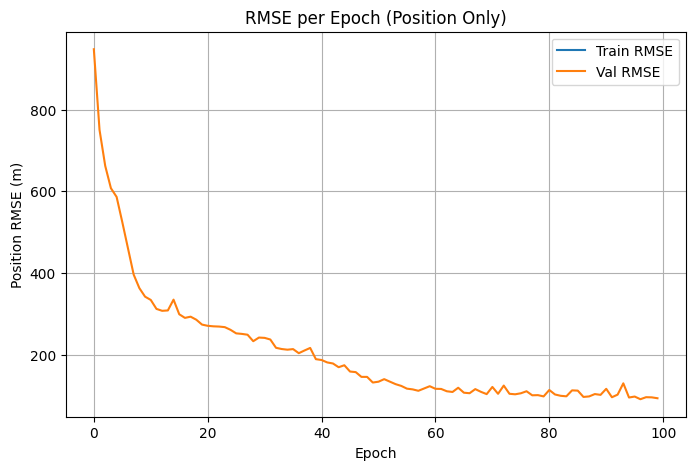

In [155]:
plt.figure(figsize=(8, 5))
plt.plot(rmse_train_pos_epochs, label='Train RMSE')
plt.plot(rmse_val_pos_epochs, label='Val RMSE')
plt.xlabel("Epoch")
plt.ylabel("Position RMSE (m)")
plt.title("RMSE per Epoch (Position Only)")
plt.grid(True)
plt.legend()
plt.show()


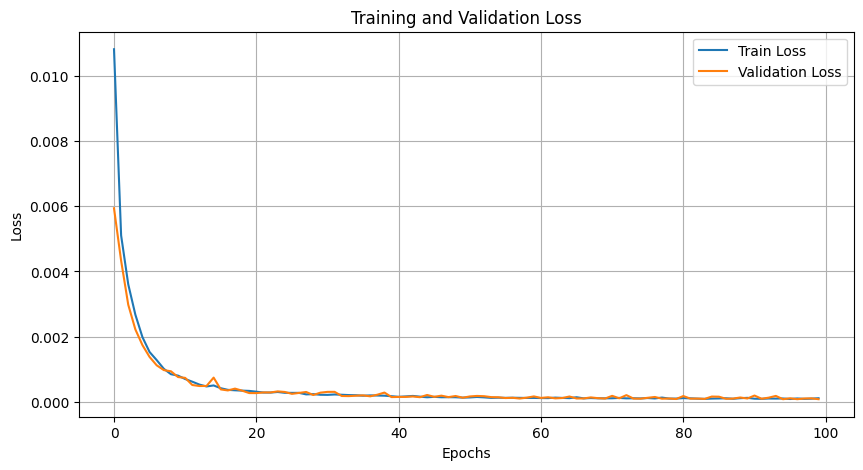

In [156]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [29]:
# load the model 
weights = "040201"

model_ik.load_state_dict(torch.load(f"weights_model_ik_{weights}.pth"))

<All keys matched successfully>

In [30]:
# Evaluate inverse kinematics model
model_ik.eval()
with torch.no_grad():
    Y_pred_ik_test = model_ik(X_ik_test)
    test_loss_ik = loss_fn_ik(Y_pred_ik_test, Y_ik_test).item()
    print("Test Loss (MSE):", test_loss_ik)

Test Loss (MSE): 0.00018422126595396549


In [31]:
Y_pred_test_original = scaler_Y_ik.inverse_transform(Y_pred_ik_test.numpy())
Y_test_original = scaler_Y_ik.inverse_transform(Y_ik_test.numpy())

# Now compute errors in original units:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_original, Y_pred_test_original)
mae = mean_absolute_error(Y_test_original, Y_pred_test_original)

# MSE represents the average of the squares of the errors, which is in original units
# MAE represents the average of the absolute differences, which is also in original units
print("Test MSE (original scale):", mse)
print("Test MAE (original scale):", mae)
# RMSE is the square root of MSE, which is also in original units
print("RMSE (original scale):", np.sqrt(mse))

Test MSE (original scale): 16283.8125
Test MAE (original scale): 77.98774719238281
RMSE (original scale): 127.60804245814603


In [32]:
Y = Y_pred_test_original.reshape(-1, 3, 3)
Y.astype(int)

print("Y_pred_test_original shape:", Y.shape)
print("Y_pred_test_original:", Y.astype(int))

Y_pred_test_original shape: (1800, 3, 3)
Y_pred_test_original: [[[    1  -259   277]
  [   60  -314   307]
  [-1513   483  1003]]

 [[-1786   -84  1868]
  [-1682   -99  1810]
  [ 1490  -445 -1107]]

 [[-1474   124  1377]
  [-1419    95  1387]
  [-1532   210  1302]]

 ...

 [[-1474  -230  1705]
  [-1373  -276  1702]
  [  501  1160 -1694]]

 [[  746   169  -881]
  [  730    90  -750]
  [  596   325  -967]]

 [[  -18 -1501  1558]
  [ -175 -1450  1695]
  [-1060   618   409]]]


In [33]:
sums = np.sum(Y, axis=2)
print(sums.shape)
print(sums)

(1800, 3)
[[ 19.419708    53.488922   -26.075623  ]
 [ -1.8962402   28.92981    -62.47339   ]
 [ 28.362427    63.653564   -18.681396  ]
 ...
 [  0.27526855  52.281982   -32.625122  ]
 [ 34.680786    70.75928    -46.009644  ]
 [ 38.7666      70.08496    -32.908173  ]]


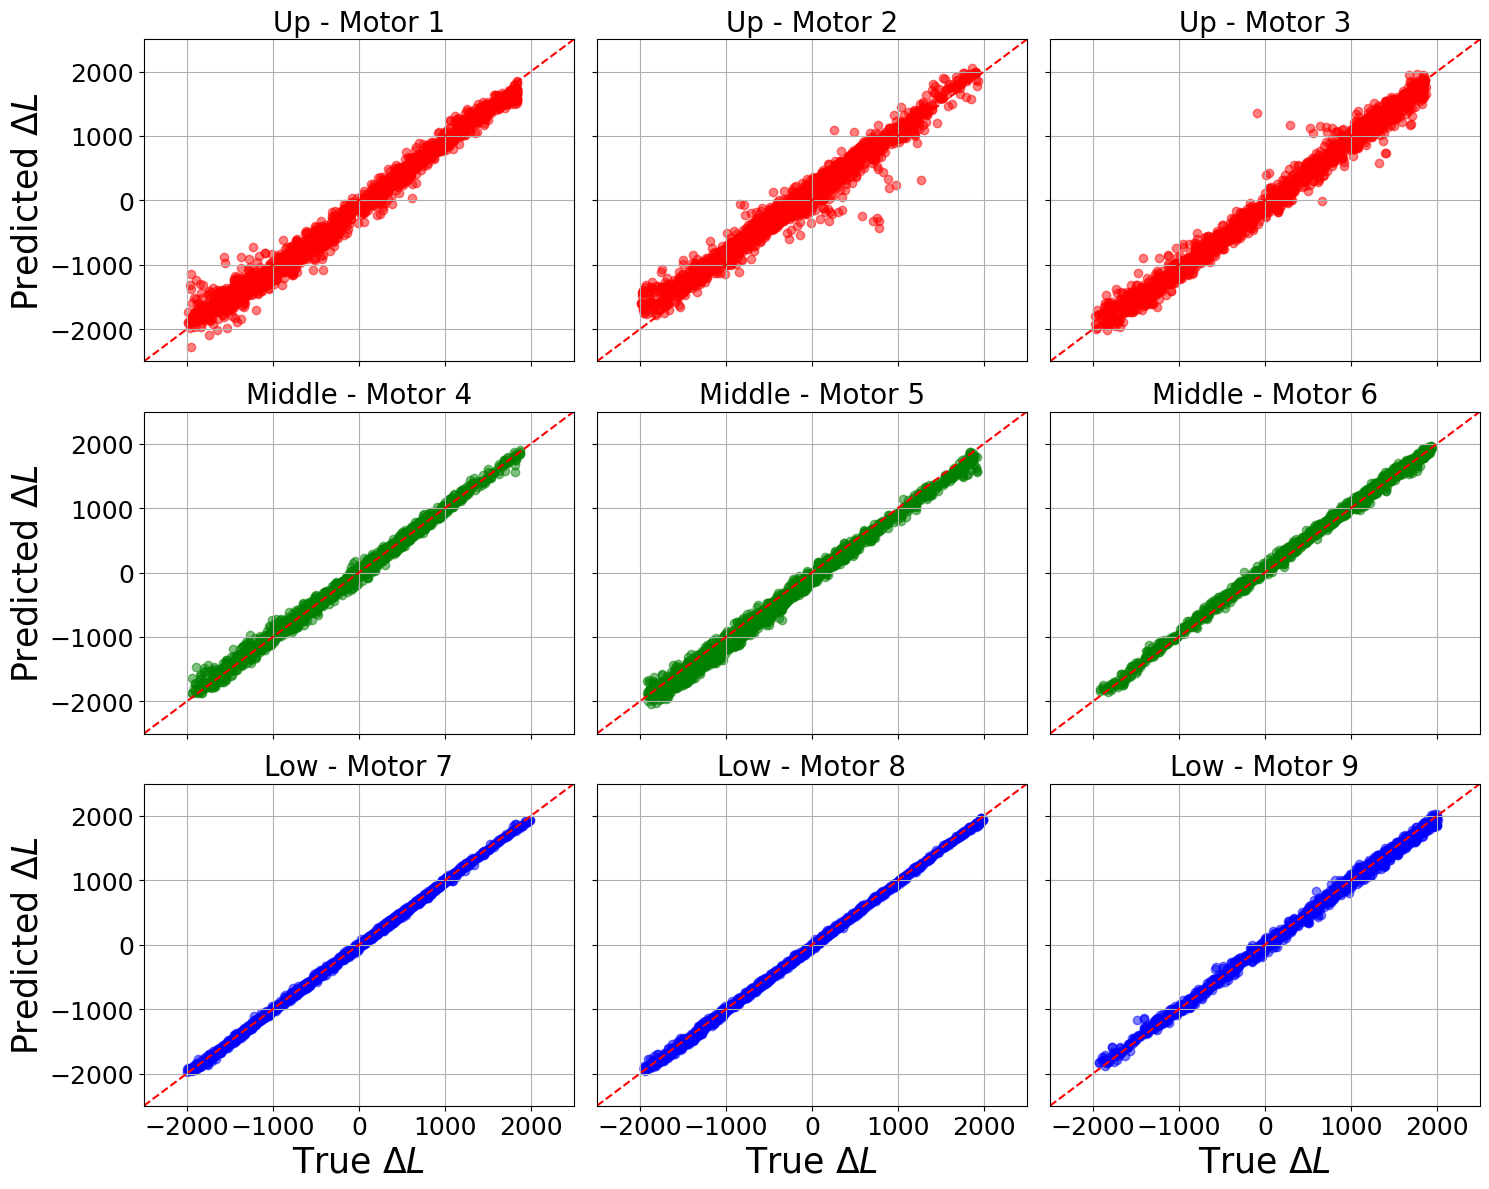

In [34]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Re-define section names and colors in the new order: Up, Middle, Low
section_labels = ['Up', 'Middle', 'Low']
section_colors = ['red', 'green', 'blue']

k = 0
for i in range(3):  # Rows: Up, Middle, Low
    section = section_labels[i]
    color = section_colors[i]
    for j in range(3):  # Motors 1–3
        ax = axes[i, j]
        # Calculate the index in original data (Low=0–2, Middle=3–5, Up=6–8)
        if section == 'Low':
            idx = j
        elif section == 'Middle':
            idx = j + 3
        else:  # section == 'up'
            idx = j + 6

        k += 1
        ax.scatter(Y_test_original[:, idx], Y_pred_test_original[:, idx], alpha=0.5, color=color)
        ax.plot([-2500, 2500], [-2500, 2500], 'r--')
        ax.tick_params(axis='both', labelsize=18)
        # Only add x-axis label on the bottom row
        if i == 2:
            ax.set_xlabel("True $\Delta L$", fontsize=25)

        # Only add y-axis label on the first column
        if j == 0:
            ax.set_ylabel("Predicted $\Delta L$", fontsize=25)
        ax.set_title(f"{section.capitalize()} - Motor {k}", fontsize=20)
        # ax.legend(loc='upper left')
        ax.grid(True)
        ax.set_xlim(-2500, 2500)
        ax.set_ylim(-2500, 2500)

plt.tight_layout()
plt.show()


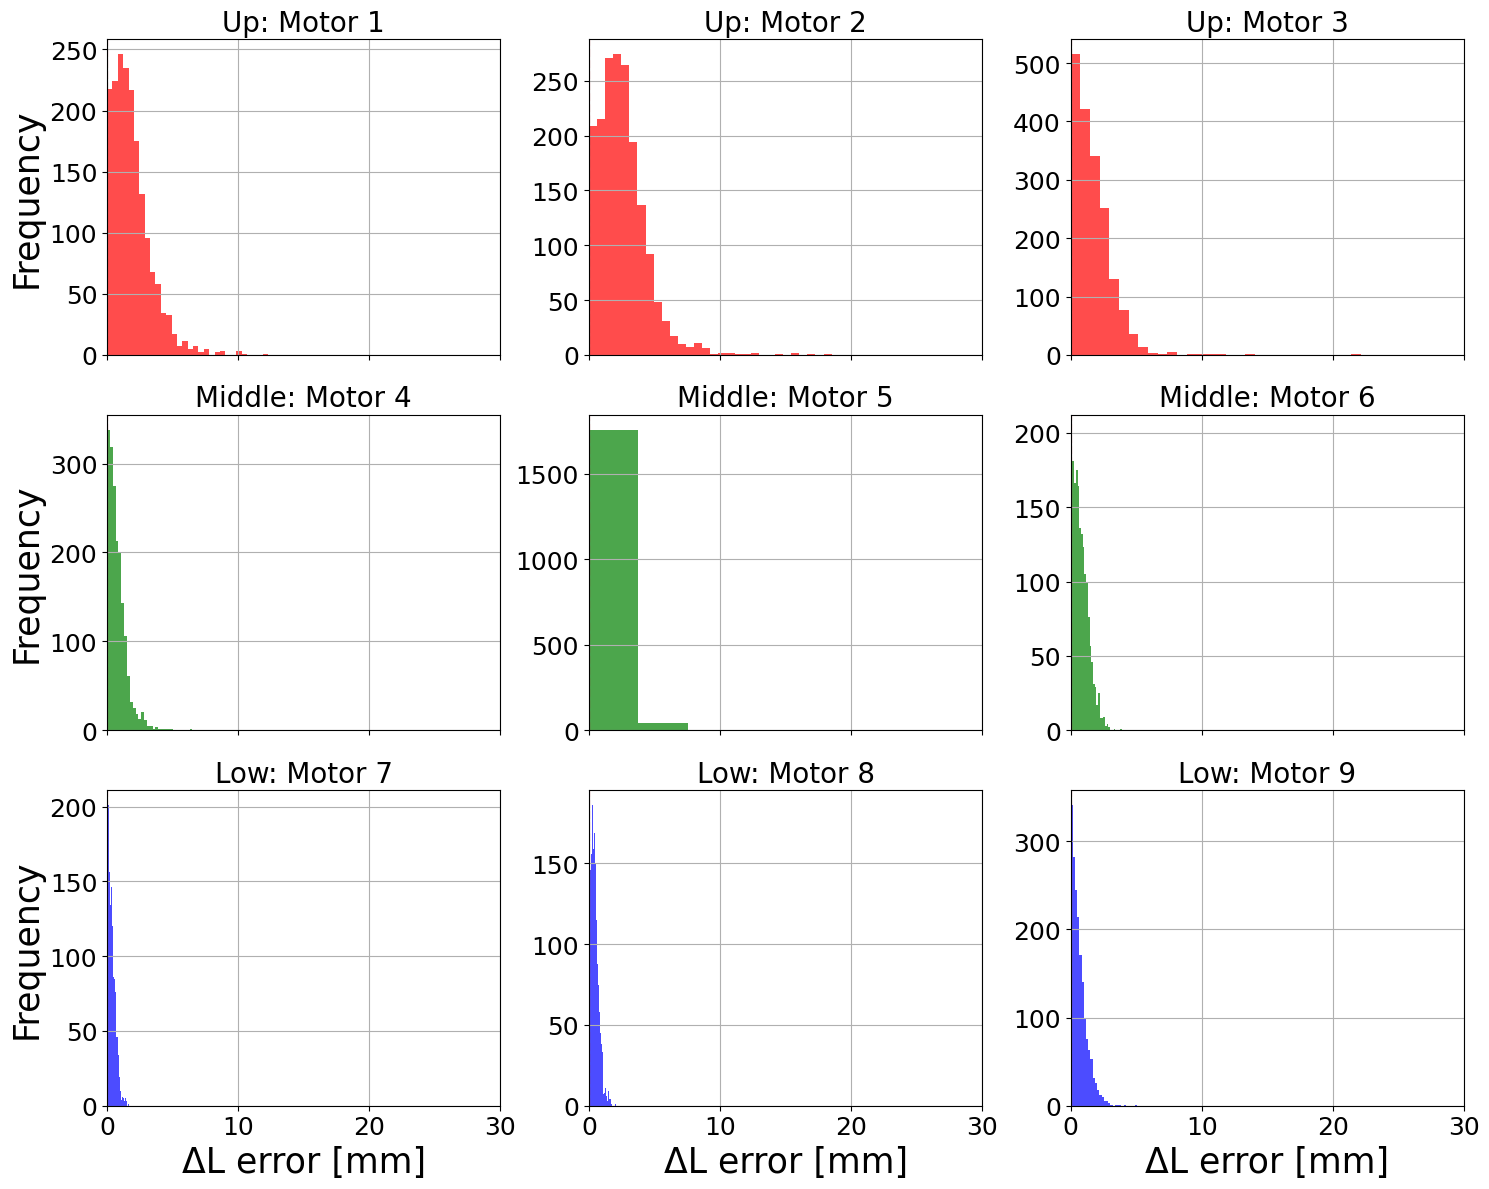

In [35]:
residuals = np.abs(Y_test_original - Y_pred_test_original)

# Convert residuals to delta L values
diff_deltaL = residuals * 0.01534

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)

# Define new order: up → middle → low
group_labels = ['Up', 'Middle', 'Low']
group_colors = ['red', 'green', 'blue']

column_indices = [6, 7, 8, 3, 4, 5, 0, 1, 2]

for plot_idx, col_idx in enumerate(column_indices):
    i = plot_idx // 3  # row
    j = plot_idx % 3   # col
    k = plot_idx + 1   # motor number
    ax = axes[i, j]
    
    ax.set_xlim(0, 30)
    # ax.set_ylim(0, 1200)

    ax.hist(diff_deltaL[:, col_idx], bins=30, alpha=0.7, color=group_colors[i])
    
    group = group_labels[i]
    ax.set_title(f"{group}: Motor {k}", fontsize=20)
    # Axis ticks
    ax.tick_params(axis='both', labelsize=18)

    # X-label only on bottom row
    if i == 2:
        ax.set_xlabel("ΔL error [mm]", fontsize=25)

    # Y-label only on first column
    if j == 0:
        ax.set_ylabel("Frequency", fontsize=25)
    ax.axvline(0, color='red', linestyle='--')
    ax.grid(True)

plt.tight_layout()
plt.show()
